In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


In [3]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


In [4]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success, tests passed!")
    
test()

Success, tests passed!


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 128
NUM_EPOCHS = 5
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01

In [7]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [8]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
#comment mnist and uncomment below if you want to train on CelebA dataset
#dataset = datasets.ImageFolder(root="/kaggle/input/celebr/", transform=transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# initialize gen and disc/critic
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

gen.train()
critic.train()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17587420.04it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 467268.78it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4329006.80it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2522580.61it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [9]:
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (data, _) in enumerate(tqdm(loader)):
        data = data.to(device)
        cur_batch_size = data.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            # clip critic weights between -0.01, 0.01
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            gen.eval()
            critic.eval()
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    data[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )
            
            gen.train()
            critic.train()

 11%|█         | 101/938 [00:55<08:35,  1.62it/s]

Epoch [0/5] Batch 100/938                   Loss D: -1.3889, loss G: 0.6862


 21%|██▏       | 201/938 [01:52<07:58,  1.54it/s]

Epoch [0/5] Batch 200/938                   Loss D: -1.5255, loss G: 0.7541


 32%|███▏      | 301/938 [02:50<06:42,  1.58it/s]

Epoch [0/5] Batch 300/938                   Loss D: -1.5368, loss G: 0.7587


 43%|████▎     | 401/938 [03:49<05:41,  1.57it/s]

Epoch [0/5] Batch 400/938                   Loss D: -1.5385, loss G: 0.7594


 53%|█████▎    | 501/938 [04:47<04:39,  1.56it/s]

Epoch [0/5] Batch 500/938                   Loss D: -1.5418, loss G: 0.7595


 64%|██████▍   | 601/938 [05:45<03:34,  1.57it/s]

Epoch [0/5] Batch 600/938                   Loss D: -1.5210, loss G: 0.7584


 75%|███████▍  | 701/938 [06:44<02:30,  1.57it/s]

Epoch [0/5] Batch 700/938                   Loss D: -1.5184, loss G: 0.7587


 85%|████████▌ | 801/938 [07:42<01:27,  1.57it/s]

Epoch [0/5] Batch 800/938                   Loss D: -1.4877, loss G: 0.7270


 96%|█████████▌| 901/938 [08:40<00:23,  1.57it/s]

Epoch [0/5] Batch 900/938                   Loss D: -1.4653, loss G: 0.7122


 11%|█         | 101/938 [00:58<08:49,  1.58it/s]

Epoch [1/5] Batch 100/938                   Loss D: -1.3206, loss G: 0.6256


 21%|██▏       | 201/938 [01:56<07:50,  1.57it/s]

Epoch [1/5] Batch 200/938                   Loss D: -1.4001, loss G: 0.6296


 32%|███▏      | 301/938 [02:55<06:43,  1.58it/s]

Epoch [1/5] Batch 300/938                   Loss D: -1.3847, loss G: 0.6943


 43%|████▎     | 401/938 [03:53<05:43,  1.56it/s]

Epoch [1/5] Batch 400/938                   Loss D: -1.3452, loss G: 0.6053


 53%|█████▎    | 501/938 [04:51<04:37,  1.58it/s]

Epoch [1/5] Batch 500/938                   Loss D: -1.3545, loss G: 0.6579


 64%|██████▍   | 601/938 [05:49<03:34,  1.57it/s]

Epoch [1/5] Batch 600/938                   Loss D: -1.3230, loss G: 0.7002


 75%|███████▍  | 701/938 [06:47<02:31,  1.57it/s]

Epoch [1/5] Batch 700/938                   Loss D: -1.3146, loss G: 0.6371


 85%|████████▌ | 801/938 [07:46<01:26,  1.58it/s]

Epoch [1/5] Batch 800/938                   Loss D: -1.2926, loss G: 0.6385


 96%|█████████▌| 901/938 [08:44<00:23,  1.57it/s]

Epoch [1/5] Batch 900/938                   Loss D: -1.2574, loss G: 0.6043


  0%|          | 3/938 [00:02<11:35,  1.34it/s]


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils


def show_images(images, title):
    # Create a grid from batch of images
    grid = vutils.make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()


In [11]:
def display_real_and_fake_images(generator, dataloader, device, num_images=32, z_dim=128):
    # Get a batch of real images
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:num_images].to(device)

    # Generate fake images
    fixed_noise = torch.randn(num_images, z_dim, 1, 1).to(device)
    generator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
    
    generator.train()

    # Display real images
    show_images(real_images, title="Real Images")

    # Display generated images
    show_images(fake_images, title="Generated Images")


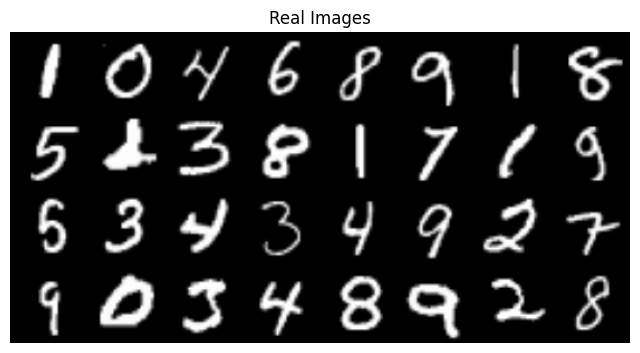

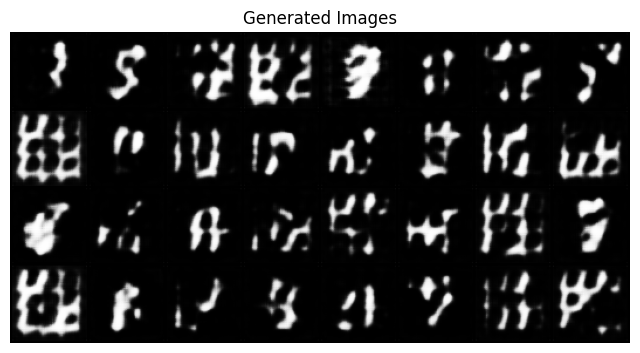

In [12]:
display_real_and_fake_images(gen, loader, device, num_images=32, z_dim=Z_DIM)

# After training for Lot more epochs, We can really have a good images generation.